# Matrix eigenvalues through Covalent

In this simple workflow we look to do some compute heavy operations of computing lots of matrix eigenvalues through Covalent. As an example we will also demonstrate the use of remote executors to offload certain compute heavy parts of the workflow and aggregate the results on the local machine

### Eigenvalues

Eigenvalues of matrices enclose special properties about a matrix and are quite relevant in quantum and classical physics. In this workflow we compute the eigenvalues of `5 x 5` matrices constructed by randomly sampling numbers from the set `[-1, 0, 1]`

In [1]:
import numpy as np
import covalent as ct
import matplotlib.pyplot as plt
from typing import List

Same as before, we functionalize our code and mark functions are `electrons` and `lattices`

Workflow steps
* Generate a random matrix of size N x N from the set `[-1, 0, 1]`
* Compute the eigenvalues of the given matrix, `M`
* Separate the real and complex parts of the eigenvalues
* Return results

In [2]:
@ct.electron
def generate_random_matrix(N: int):
    return np.random.choice([-1, 0, 1], N*N).reshape(N, N)

In [3]:
@ct.electron
def compute_eigenvalues(M: np.ndarray):
    eig, _ = np.linalg.eig(M)
    return eig

In [4]:
@ct.electron
def get_real_part(eigenvalues: List[float]):
    return [np.real(eig) for eig in eigenvalues]


@ct.electron
def get_imag_part(eigenvalues: List[float]):
    return [np.imag(eig) for eig in eigenvalues]

Create the lattice that takes as an input, how many iterations of eigenvalues computations must be carried out

In [5]:
@ct.lattice
def eigenvalue_workflow(N: int, batch_size: int):
    real_part = []
    imag_part = []
    for index in range(batch_size):
        matrix = generate_random_matrix(N)
        eigenvalues = compute_eigenvalues(matrix)
        real_part.append(get_real_part(eigenvalues))
        imag_part.append(get_imag_part(eigenvalues))
    return np.asarray(real_part).flatten(), np.asarray(imag_part).flatten()

In [6]:
dispatch_id = ct.dispatch(eigenvalue_workflow)(5, 20)
result = ct.get_result(dispatch_id, wait=True)

In [7]:
real_part, imag_part = result.result

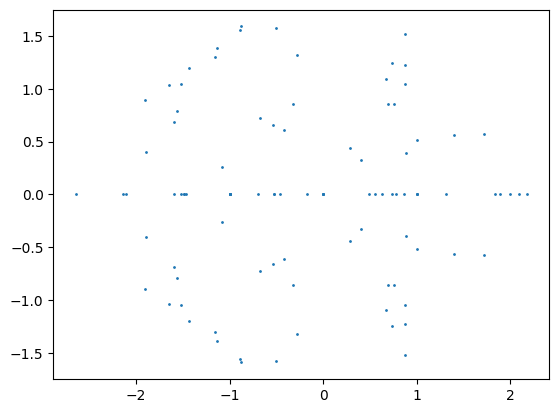

In [8]:
plt.plot(real_part, imag_part, 'o', ms=1)

### Increasing the number of iterations will make the workflow compute heavy, we can offload the computation to a remote machine and collect the results

```python
from covalent.executor import SSHExecutor

executor = ct.executor.SSHExecutor(
    username="user",
    hostname="host2.hostname.org",
    remote_cache_dir="/tmp/covalent",
    ssh_key_file="/home/user/.ssh/host2/id_rsa"
)
```

The `SSHExecutor` plugin can be installed via `pip` as follows

```bash
pip install covalent-ssh-plugin
```

In [9]:
from covalent.executor import SSHExecutor
import os

In [10]:
ec2_ssh=SSHExecutor(username="ubuntu",
                hostname=os.environ['EC2_HOSTNAME'],
                ssh_key_file="~/.ssh/covalent_ieee_demo.pem")

local_ssh=SSHExecutor(username="venkat", hostname="192.168.3.198", ssh_key_file="~/.ssh/id_ed25519")

### Create a sub-lattice

* Mark all electrons to be executed on the remote machine via the SSHExecutor
* Mark `eigenvalue_workflow` as an `electron` to create a sublattice
* Define a new workflow that makes multiple invocations of `eigenvalue_workflow` to compute lots of eigenvalues

In [18]:
@ct.electron(executor=local_ssh)
#@ct.electron(executor=ec2_ssh)
def generate_random_matrix(N: int):
    return np.random.choice([-1, 0, 1], N*N).reshape(N, N)

@ct.electron(executor=local_ssh)
#@ct.electron(executor=ec2_ssh)
def compute_eigenvalues(M: np.ndarray):
    eig, _ = np.linalg.eig(M)
    return eig

@ct.electron(executor=local_ssh)
#@ct.electron(executor=ec2_ssh)
def get_real_part(eigenvalues: List[float]):
    return [np.real(eig) for eig in eigenvalues]

@ct.electron(executor=local_ssh)
#@ct.electron(executor=ec2_ssh)
def get_imag_part(eigenvalues: List[float]):
    return [np.imag(eig) for eig in eigenvalues]


@ct.electron(executor=local_ssh)
#@ct.electron(executor=ec2_ssh)
@ct.lattice
def eigenvalue_workflow(N: int, batch_size: int):
    real_part = []
    imag_part = []
    for index in range(batch_size):
        matrix = generate_random_matrix(N)
        eigenvalues = compute_eigenvalues(matrix)
        real_part.append(get_real_part(eigenvalues))
        imag_part.append(get_imag_part(eigenvalues))
    return np.asarray(real_part).flatten(), np.asarray(imag_part).flatten()


@ct.lattice
def compute_workflow(N: int, epochs: int, batch_size: int):
    real_part = []
    imag_part = []
    for i in range(epochs):
        re, imag = eigenvalue_workflow(N, batch_size)
        real_part.append(re)
        imag_part.append(imag)
    return np.asarray(real_part).flatten(), np.asarray(imag_part).flatten()

### Dispatch the larger workflow

In [19]:
dispatch_id = ct.dispatch(compute_workflow)(5, 1, 10)

In [20]:
result = ct.get_result(dispatch_id, wait=True)

In [21]:
real, imag = result.result

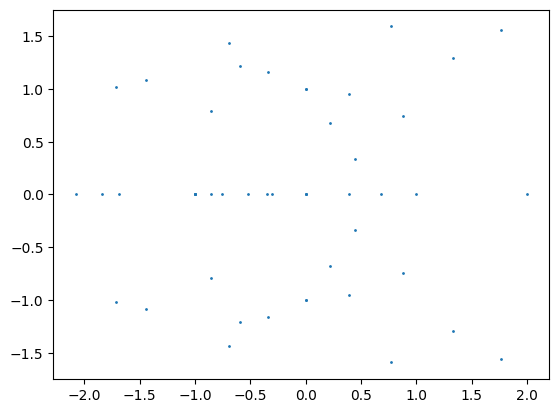

In [22]:
plt.plot(real, imag, 'o', ms=1)